# Wrangling Boston: A Case Study with OpenStreetMaps

Within this document I will endeavour to extract, clean, and discuss the various aspects of the Boston, MA - OpenStreetMaps data. This file, uncompressed, is approximately *500 MB*. Due to it's **massive** size, I've had to deal with many new issues, issues such as running out of memory, issues that I had previously avoided completely. To work through the task I ended up digging into many docs, and came out a better coder as a result. 

Thank you, for posing this challenge, and thank you for judging my performance. 

Please respond with any questions you may have.

## Introduction
As a "New Englander" I've always held [Boston](https://en.wikipedia.org/wiki/Boston) fondly in my mind. Personally, the city has always struck me as warm, with it's winding and inefficient city-planning. The natural counter to New York (a city of gridlines and efficiency), Boston is the ideal place to work on StreetMapData, as visitors need all the help they can get navigating the web of streets. 

## Imports
For this project I'll be using a few standard libraries, the task will be completed mainly with Pandas, Numpy, and SQLite3. 

I've also imported matplotlib to plot any interesting findings, as well as bz2 to handle the format provided by [MapZen](https://mapzen.com/data/metro-extracts/metro/boston_massachusetts/). 

In [1]:
import sqlite3 as sql
import os
import xml.etree.cElementTree as ET
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Also going to left-align tables, as I feel it reads much nicer; thank you to [Stack Overflow](http://stackoverflow.com/questions/21892570/ipython-notebook-align-table-to-the-left-of-cell) for this one.

In [2]:
%%html
<style>
table {float:left}
</style>

## Setup

This is where I inteded to begin exploring data, and met my first file-size-based issue. 

Unfortunately, I'm on a 32-bit system; and because of my work - I need to stay in 32-bit land. This means that my memory is severely restricted, and as a result I was forced to find a method for parsing the file, building the database, and managing my memory. 

First, to look at my schema:

```python
# This is my schema, and controlled the layout of the database.
users = (
    "CREATE TABLE IF NOT EXISTS users ("
    "u_id integer PRIMARY KEY,"
    "u_name text NOT NULL"
    ");"
)
nodes = (
    "CREATE TABLE IF NOT EXISTS nodes ("
    "n_id integer PRIMARY KEY,"
    "u_id integer NOT NULL,"
    "lat text NOT NULL,"
    "lon text NOT NULL,"
    "FOREIGN KEY (u_id) REFERENCES users (u_id) ON DELETE CASCADE ON UPDATE NO ACTION"
    ");"
)
node_tags = (
    "CREATE TABLE IF NOT EXISTS node_tags ("
    "n_id integer NOT NULL,"
    "k text NOT NULL,"
    "v text NOT NULL,"
    "PRIMARY KEY (n_id, k)"
    "FOREIGN KEY (n_id) REFERENCES nodes (n_id) ON DELETE CASCADE ON UPDATE NO ACTION"
    ");"
)
ways = (
    "CREATE TABLE IF NOT EXISTS ways ("
    "w_id integer PRIMARY KEY,"
    "u_id integer NOT NULL,"
    "FOREIGN KEY (u_id) REFERENCES users (u_id) ON DELETE CASCADE ON UPDATE NO ACTION"
    ");"
)
way_tags = (
    "CREATE TABLE IF NOT EXISTS way_tags ("
    "w_id integer NOT NULL,"
    "k text NOT NULL,"
    "v text NOT NULL,"
    "PRIMARY KEY (w_id, k),"
    "FOREIGN KEY (w_id) REFERENCES ways (w_id) ON DELETE CASCADE ON UPDATE NO ACTION"
    ");"
)
way_refs = (
    "CREATE TABLE IF NOT EXISTS way_refs ("
    "w_id NOT NULL,"
    "n_id NOT NULL,"
    "PRIMARY KEY (w_id, n_id),"
    "FOREIGN KEY (n_id) REFERENCES nodes (n_id) ON DELETE CASCADE ON UPDATE NO ACTION"
    ");"
)
relations = (
    "CREATE TABLE IF NOT EXISTS relations ("
    "r_id integer PRIMARY KEY,"
    "k text NOT NULL,"
    "v text NOT NULL"
    ");"
)
relation_members = (
    "CREATE TABLE IF NOT EXISTS relation_members ("
    "r_id NOT NULL,"
    "m_id NOT NULL,"
    "m_type NOT NULL,"
    "PRIMARY KEY (r_id, m_id, m_type),"
    "FOREIGN KEY (r_id) REFERENCES relations (r_id) ON DELETE CASCADE ON UPDATE NO ACTION"
    ");"
)
```

Memory management proved to be quite difficult, and the following code needed over **3 days** to run on my machine! 

Below, in order, is a reset_db function (which I used while building my parse function to reset between parses as I cleaned up unexpected errors), then a fill_tables function, which actually parses the tables out. 

```python
# this code resets the database, and was used when my "fill_tables" code broke midstream.
def reset_db(db_name):
    """Completely resets the database. Caution as this deletes the file, and recreates all tables."""
    if os.path.isfile(db_name): os.remove(db_name)
    conn = sql.connect(db_name)
    c = conn.cursor()
    try:
        c.execute(users)
        c.execute(nodes)
        c.execute(node_tags)
        c.execute(ways)
        c.execute(way_tags)
        c.execute(way_refs)
        c.execute(relations)
        c.execute(relation_members)
    except Exception as err:
        print("err")
        conn.rollback()
    conn.commit()
    conn.close()
    return
```

```python
# this code parses the file, iterating over each element, and injects it into the database
def fill_tables(file, db_name):
    """Fill the database from file
    
    This function parses the provided file, while keeping the root element clear it iterates through and parses elements
    It then takes these elements and injects them into the DB using sqlite's "INSERT OR IGNORE"
    """
    # connect to the sql server and generate a cursor object
    conn = sql.connect(db_name)
    c = conn.cursor()
    # parent attributes, which are set each time a parent element is found
    parent = False
    p_type = ''
    context = ET.iterparse(file, events=("start", "end"))
    # turn the iterparse into an iterator
    context = iter(context)
    # get the root element using next on the iterator object, which gets the first element in the file
    event, root = next(context)
    for event, e in context:
        try:
            # handle tags and nds, commiting on success
            try:
                if e.tag == 'tag' and parent:
                    tag_attribs = (parent, e.attrib['k'], e.attrib['v'])
                    if p_type == 'node': 
                        c.execute(
                            "INSERT OR IGNORE INTO node_tags(n_id, k, v) VALUES(?, ?, ?)", 
                            (tag_attribs)
                        )
                    if p_type == 'way': 
                        c.execute(
                            "INSERT OR IGNORE INTO way_tags(w_id, k, v) VALUES(?, ?, ?)", 
                            (tag_attribs)
                        )
                elif e.tag == 'nd' and p_type == 'way':
                    way_ref_attribs = (parent, e.attrib['ref'])
                    c.execute(
                        "INSERT OR IGNORE INTO way_refs(w_id, n_id) VALUES(?, ?)", 
                        (way_ref_attribs)
                    )
                elif e.tag == 'nd' and p_type == 'relation':
                    print(e.tag, e.attrib, p_type)
                elif e.tag == 'nd' and p_type == 'node':
                    print(e.tag, e.attrib, p_type)
            except KeyError:
                print("bad tag: {}".format(e.attrib))
                pass
            else:
                conn.commit()
            
            # handle users
            try:
                u_id = e.attrib['uid']
                u_name = e.attrib['user']
                c.execute("INSERT OR IGNORE INTO users(u_id, u_name) VALUES(?, ?)", (u_id, u_name))
            except KeyError:
                pass
            else:
                conn.commit()
            
            # check for id, if there's no ID it's an invalid parent object, we can skip that
            try:
                e_id = e.attrib['id']
            except KeyError:
                conn.commit()
                root.clear()
                continue            
            # node / way / relation checks
            try:
                if e.tag == 'node': 
                    node_attribs = (e_id, u_id, e.attrib['lat'], e.attrib['lon'])
                    c.execute(
                        "INSERT OR IGNORE INTO nodes(n_id, u_id, lat, lon) VALUES(?, ?, ?, ?)", 
                        (node_attribs)
                    )
                    parent, p_type = e_id, 'node'
                elif e.tag == 'way':
                    way_attribs = (e_id, u_id)
                    c.execute(
                        "INSERT OR IGNORE INTO ways(w_id, u_id) VALUES(?, ?)", 
                        (way_attribs)
                    )
                    parent, p_type = e_id, 'way'
                elif e.tag == 'relation':
                    relation_attribs = (e_id, e.attrib['k'], e,attrib['v'])
                    c.execute(
                        "INSERT OR IGNORE INTO relations(r_id, k, v) VALUES(?, ?, ?)", 
                        (relation_attribs)
                    )
                    parent, p_type = e_id, 'relation'
            except KeyError:
                print("bad parent")
                pass
            else: 
                conn.commit()
            
            #catch and commit any other changes(this clears the journal which saves mem)
            conn.commit()
            # clear the root element, which saves a ton of mem
            root.clear()
        except KeyboardInterrupt:
            conn.commit()
            root.clear()
            input("paused")
            continue
        except Exception as err:
            conn.commit()
            input("unhandled err: {} Tag: {}={} parent: {}".format(err, e.tag, e.attrib, p_type))
            continue
    print("exiting loop")
    conn.commit()
    conn.close()
    input()
    return
```

All of these functions were *not* run in Jupyter, as it seemed to be slightly more error prone (and a bit slower?). Instead, I elected to run the code from terminal, and bring the code back into here to explain. 

## Exploration of Data

So at this point, we have all of the valid elements and their children stored in a database.

The original file was over 500 MB in size; the database came in at 250 MB. Nearly halving the data through some dedicated normalization! Woohoo! (The database is currently in 3rd normal form for those who are curious)

It's at this point that I truly began to explore the SQLite DB File with a few SQL Queries. 

I performed many of these queries initially through [DB Browser for SQLite's](http://sqlitebrowser.org) Execute SQL Panel. I really enjoyed using the interface provided by the program, especially autocompletion for tables, and fields.

Fairly shortly into the analysis I started pulling entire tables into [Pandas](http://pandas.pydata.org/pandas-docs/stable/index.html) and running queries off of these [Pandas DataFrames](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)

### Who's creating this data?

The first question I'd like to look at is, who's creating this data? 

To find out, I looked at the top 500 users who were responsible for most of the nodes in the map. 

```sql
SELECT users.u_name, count(*) as cnt
FROM nodes, users, ways
WHERE nodes.u_id = users.u_id
GROUP BY users.u_id
ORDER BY cnt desc
LIMIT 500
```

The top 10 in table:

| user | Count|
|:------|:------|
|crschmidt | 1201241 |
|jremillard-massgis | 198117|
|OceanVortex | 85290|
|wambag | 73269|
|morganwahl | 67532|
|MassGIS Import | 56820|
|ryebread | 52372|
|ingalls_imports | 28241|
|Ahlzen | 24944|
|mapper999 | 12510|


#### Breaking down the table
Okay, that is a fairly large jump. 

For a bit of context, GIS is a typical abbreviation for a Geographic Information System. I've had the fortune to work with a few of these systems and they are loaded with data. We can see the "jremillard-massgis" user, and we can safely assume such a large volume was an import from one of the many GIS Systems. There is also the user called "MassGIS Import" I think it's also fair to say this was a GIS Import as well. What I cannot explain, is user "crshmidt", who mapped more than any user, and yet references no outside software. 

Immediately I wanted to see how realistic this *could* even be:

In [3]:
from datetime import date
# when I imported the data
d1 = date(2017, 4, 1)
# when OSM was founded
d0 = date(2004, 8, 9)
delta = d1 - d0
nodes = 1201241
nodes_per_day = nodes / delta.days
nodes_per_hour = nodes_per_day / 24
nodes_per_waking_hour = nodes_per_day / (24-10)
nodes_per_minute = nodes_per_waking_hour / 60

line = (
    f"crshmidt has posted: "
    f"\n{nodes_per_day:>10.2f} nodes per day, "
    f"\n{nodes_per_hour:>10.2f} nodes per hour *assumes posting 24 hours per day, "
    f"\n{nodes_per_waking_hour:>10.2f} nodes per hour *assumes normal waking hours, "
    f"\n{nodes_per_minute:>10.2f} nodes per waking minute"
)
print(line)

crshmidt has posted: 
    260.12 nodes per day, 
     10.84 nodes per hour *assumes posting 24 hours per day, 
     18.58 nodes per hour *assumes normal waking hours, 
      0.31 nodes per waking minute


#### Understanding our top user
I simply can't understand how one user can output so much data over 12 years consistently. Remember the numbers above don't account for family time, weekends off, or anything really - except posting to OSM. My suspicion is that this account is shared by a large group of people.

Before chasing down this specific user too much further, I'd like to take a moment to create a collection of histograms mapping posting frequency across different segments of our top 500. Essentially I'm looking to see what most user habits look like.

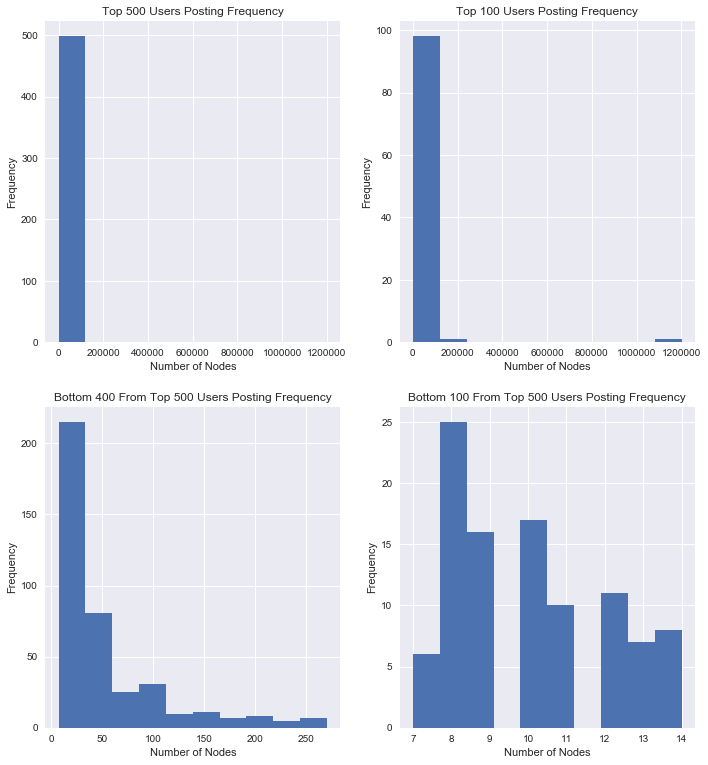

In [4]:
# to graph user contribution:
node_users = pd.read_csv("./wrangle_openstreetmaps_boston_results/nodes_users_top50.csv")
fig, axes = plt.subplots(2, 2, figsize=(18, 13))

# plot 1
ax1 = plt.subplot2grid((2, 3), (0,0))
n, bins, rectangles = plt.hist(node_users['cnt'])
plt.title("Top 500 Users Posting Frequency")
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency")

# plot 2
ax2 = plt.subplot2grid((2, 3), (0, 1))
n, bins, rectangles = plt.hist(node_users['cnt'][0:100])
plt.title("Top 100 Users Posting Frequency")
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency")

# plot 3
ax3 = plt.subplot2grid((2, 3), (1,0))
n, bins, rectangles = plt.hist(node_users['cnt'][100:500])
plt.title("Bottom 400 From Top 500 Users Posting Frequency")
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency")

# plot 4
ax3 = plt.subplot2grid((2, 3), (1, 1))
n, bins, rectangles = plt.hist(node_users['cnt'][400:500])
plt.title("Bottom 100 From Top 500 Users Posting Frequency")
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency")

# show, but with ";" because for some reason that stops the text from showing?
plt.show();

#### Users Histogram Explanation 
We have a very skewed, yet very expected, distribution for user input. Most userts contribute relavtively few nodes, whereas we can also see a few key users who contribute a very large number of nodes. 

Thanks to [Stack Overflow](http://stackoverflow.com/questions/25790062/how-to-hide-matplotlib-lines-line2d-in-ipython-notebook) for a method to block text from iPython notebooks. 

#### Gathering all of the users
To really get a better understanding of the user habits regarding both nodes and ways, I'm going to load the entire user table up into a Pandas DataFrame. From there I'll perform a bit more in-depth statistical analysis. Which will hopefully illuminate the true nature of the Boston OSM users across both nodes and ways.

>#### Caution, error ahead. 
So, during my analysis I committed a pretty bad error. I intended to load the entire user table, and accidently left a limit statement in. In my haste I completely forgot to change it as I progressed through my analysis. I then noticed I had nodes without corresponding u_names, (as in, they had their u_id, but no corresponding u_name), resulting from my limiting of the user table import.
I've cut that entire section out and put in below in a section marked **Aside: Missing Users** as an example of how I would correct this problem if it did, in fact, exist.

In [5]:
# connect to our db:
conn = sql.connect('bostonV2_python.db')
sql_select = (
    "SELECT users.u_name as u_name_{0}, users.u_id, count(*) as cnt_{0} "
    "FROM {0}, users "
    "WHERE users.u_id = {0}.u_id "
    "GROUP BY users.u_id "
    "ORDER BY cnt_{0} desc "
)
# get our users and a count of their contributions to the nodes and ways
users = pd.concat(
    objs = [
        pd.read_sql(sql_select.format("nodes"), con=conn, index_col="u_id"), 
        pd.read_sql(sql_select.format("ways"), con=conn, index_col="u_id")
    ],
    axis=1,
    join='outer',
)
# add a grand total
users['cnt_total'] = users['cnt_nodes'] + users['cnt_ways']
# sort the df by total, nodes, then ways desc so we can see our top users
users.sort_values(
    by=['cnt_total', 'cnt_nodes','cnt_ways'],
    ascending=False, 
    inplace=True
)
# fill NaNs with 0
users.fillna(0, axis=1, inplace=True)
# cast as uint32, which takes slightly less memory than float64 (which is default)
users = users.astype(dtype={'cnt_nodes':np.uint32, 'cnt_ways': np.uint32})
users['u_name'] = users['u_name_ways']
users.drop(['u_name_ways', 'u_name_nodes'], inplace=True, axis=1)
# print the head to make sure we're on the right track
users.head()

,cnt_nodes,cnt_ways,cnt_total,u_name
u_id,,,,
1034,1201241,1280,1202521.0,crschmidt
1137433,198117,231748,429865.0,jremillard-massgis
354704,85290,6749,92039.0,OceanVortex
326503,73269,6827,80096.0,wambag
221294,67532,1886,69418.0,morganwahl


In [6]:
# build the table out:
num_nodes = sum(users['cnt_nodes'])
num_ways = sum(users['cnt_ways'])
num_total = num_nodes + num_ways
num_users = len(users['u_name'])
users['per_nodes'] = users['cnt_nodes'] / num_nodes
users['per_ways'] = users['cnt_ways'] / num_ways
users['per_total'] = users['cnt_total'] / num_total

In [7]:
print(f"There are {num_users} users mapping in Boston.")
print(f"They've mapped a total of {num_total} objects, of which {num_ways} are ways, and {num_nodes} are nodes.")
users.head()

There are 1345 users mapping in Boston.
They've mapped a total of 2243380 objects, of which 309396 are ways, and 1933984 are nodes.


,cnt_nodes,cnt_ways,cnt_total,u_name,per_nodes,per_ways,per_total
u_id,,,,,,,
1034,1201241,1280,1202521.0,crschmidt,0.621123,0.004137,0.536031
1137433,198117,231748,429865.0,jremillard-massgis,0.102440,0.749034,0.191615
354704,85290,6749,92039.0,OceanVortex,0.044101,0.021813,0.041027
326503,73269,6827,80096.0,wambag,0.037885,0.022066,0.035703
221294,67532,1886,69418.0,morganwahl,0.034919,0.006096,0.030943


#### Pie Chart of User Input to All Objects
Next I'd like to see OSMs users in a pie chart. For readability I'm only going to chart 90% of total elements. Relatively few users have created this content, as can be seen below 

In [8]:
def piechart_users(num_contrib, df, sort_col='cnt_total'):
    # sort by sort_col, then take num_contrib off the top
    pie_data = df.sort_values(by=sort_col, ascending=False)
    pie_data = pie_data.iloc[:num_contrib]
    sum_pie_data = pie_data.sum(axis=0, numeric_only=True)
    # generate 'other' index containing the rest of the elements from the unselected group
    other = 1 - sum_pie_data
    other[other < 0] = 0
    other['cnt_nodes'] = num_nodes - sum_pie_data['cnt_nodes']
    other['cnt_ways'] = num_ways - sum_pie_data['cnt_ways']
    other['cnt_total'] = num_total - sum_pie_data['cnt_total']
    other['u_name'] = "other"
    pie_data.loc[-1] = other
    # pie chart
    labels = pie_data['u_name']
    sizes = pie_data['cnt_total']

    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(111)
    ax.pie(sizes, labels=labels, autopct='%1.0f%%', labeldistance=1.05)
    ax.set_title(f"Top {num_contrib} OSM User Contributions to all Objects")
    plt.show();
    print(
        f"Top {num_contrib} OSM Users account for: "
        f"\n{sum_pie_data['per_total']:>10.2%} of total ojects, "
        f"\n{sum_pie_data['per_nodes']:>10.2%} of total nodes, "
        f"\n{sum_pie_data['per_ways']:>10.2%} of total ways."
    )
    return pie_data, sum_pie_data

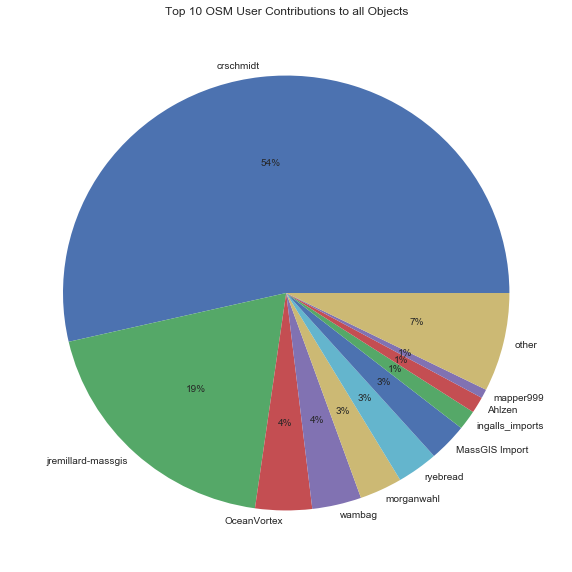

Top 10 OSM Users account for: 
    92.66% of total ojects, 
    93.09% of total nodes, 
    89.98% of total ways.


,cnt_nodes,cnt_ways,cnt_total,u_name,per_nodes,per_ways,per_total
u_id,,,,,,,
1034,1201241.0,1280.0,1202521.0,crschmidt,0.621123,0.004137,0.536031
1137433,198117.0,231748.0,429865.0,jremillard-massgis,0.102440,0.749034,0.191615
354704,85290.0,6749.0,92039.0,OceanVortex,0.044101,0.021813,0.041027
326503,73269.0,6827.0,80096.0,wambag,0.037885,0.022066,0.035703
221294,67532.0,1886.0,69418.0,morganwahl,0.034919,0.006096,0.030943
3216582,52372.0,14643.0,67015.0,ryebread,0.027080,0.047328,0.029872
15750,56820.0,6408.0,63228.0,MassGIS Import,0.029380,0.020711,0.028184
1137518,28241.0,4220.0,32461.0,ingalls_imports,0.014602,0.013639,0.014470
81285,24944.0,2187.0,27131.0,Ahlzen,0.012898,0.007069,0.012094


In [9]:
pie_data, sum_pie_data = piechart_users(num_contrib=10, df=users)
pie_data

#### More clutter, please!
Now to be not so readable, but contain almost all of the data (>99%):

In [ ]:
pie_data, sum_pie_data = piechart_users(num_contrib=301, df=users)

#### Summarizing Users
It turns out, most of Boston has been mapped by a single user. This means any errors we may find under that name should be fairly widespread, and also those found elsewhere should be rather singular, as most users have fairly few posts. Even if one particular user did not understand the guidelines at the time of posting, the impact of such errors will be relatively small. 

What this cannot account for is a common misunderstanding of instructions, rather it relies on an average person fully grapsing and adhearing to the posted rules. 

With that understanding it's time to begin focusing on the nodes and their relative tags.

### Nodes and Their Tags
Let's journey through the node_tags table first, getting a sense of what tags are commonly associated with nodes.

In [11]:
sql_select = (
    "SELECT * "
    "FROM node_tags "
)
node_tags = pd.read_sql(sql_select, conn)
num_node_tags = len(node_tags)

sql_select = (
    "SELECT * "
    "FROM nodes"
)
nodes = pd.read_sql(sql_select, con=conn, index_col="n_id")

nodes_without_tags = nodes[~nodes.index.isin(node_tags['n_id'])]
num_nodes_without_tags = len(nodes_without_tags)

print(f"There are {num_node_tags} node tags in the database. \nLeaving {num_nodes_without_tags} nodes without tags")

print("\nHere is a sample of some node tags:")
node_tags.head()

There are 293836 node tags in the database. 
Leaving 1830154 nodes without tags

Here is a sample of some node tags:


,n_id,k,v
0,31419556,name,Firebrand Saints
1,31419556,amenity,restaurant
2,31419650,url,http://www.mbta.com/schedules_and_maps/subway/...
3,31419650,name,Kendall/MIT
4,31419650,railway,subway_entrance


Interesting! There seems to be many nodes without any tag fields. Rather odd in my opinion, but I suppose some nodes may just be placeholders, or waypoints for other objects. 
Now that we've gotten the table loaded, let's get a value count of the keys (k field):

In [12]:
pd.value_counts(node_tags['k'].values.ravel())

source                             89590
attribution                        89026
created_by                         32182
name                               10256
highway                             8707
operator                            5323
amenity                             5085
ref                                 4926
network                             4765
public_transport                    4661
bus                                 4610
addr:housenumber                    1807
addr:street                         1806
ele                                 1710
gnis:feature_id                     1561
natural                             1525
man_made                            1389
addr:postcode                       1149
addr:city                           1101
gnis:created                        1057
addr:state                          1032
gnis:county_id                      1020
gnis:state_id                       1019
shop                                 784
phone           

Looking a bit closer at our top few tags, source attribution and created_by are all by definition, quite similar. The terms are almost completely interchangable. I think this warrants a further level of exploration:

In [13]:
# what values are linked to the source k tag:
pd.value_counts(node_tags[node_tags.k == "source"]['v'].values.ravel())

massgis_import_v0.1_20071008193615                                                                            42291
massgis_import_v0.1_20071009092358                                                                             9984
massgis_import_v0.1_20071009101959                                                                             7544
massgis_import_v0.1_20071009091249                                                                             5327
massgis_import_v0.1_20071009091627                                                                             5017
massdot_import_081211                                                                                          4534
massgis_import_v0.1_20071009102616                                                                             3814
massgis_import_v0.1_20071009092815                                                                             2252
massgis_import_v0.1_20071009094650                                      

In [14]:
# what values are linked to the attribution k tag:
pd.value_counts(node_tags[node_tags.k == "attribution"]['v'].values.ravel())

Office of Geographic and Environmental Information (MassGIS)                                                                             84181
massDOT                                                                                                                                   4610
Office of Geographic and Environmental Information (MassGIS), Massachusetts Emergency Management Agency                                    111
USGS 2001 County Boundary                                                                                                                   94
Office of Geographic and Environmental Information (MassGIS), Commonwealth of Massachusetts Executive Office of Environmental Affairs       24
Office of Geographic and Environmental Information (MassGIS), Massachusetts Emergency Management Agency (MEMA)                               6
dtype: int64

In [15]:
# what values are linked to the created_by k tag:
pd.value_counts(node_tags[node_tags.k == "created_by"]['v'].values.ravel())

JOSM               32123
Potlatch 0.10f        51
Merkaartor 0.12        3
Merkaartor 0.13        2
xybot                  2
iLOE 1.9               1
dtype: int64

#### Top 3 Node_Tags
Well our top three tags have turned over some relatively useful information. We can see Mass GIS makes up a huge number of the nodes, with JOSM also accounting for a fair portion. I'd like to examine what users have created these GIS, and JOSM tagged nodes. Let's look at the nodes head.

In [16]:
nodes.head()

,u_id,lat,lon
n_id,,,
30730952,326503,42.3678097,-71.0218711
30730953,326503,42.3677364,-71.0218568
30730954,326503,42.3676084,-71.0218168
30730955,326503,42.3675229,-71.0218486
30730956,326503,42.3674548,-71.0218865


#### GIS Uploaded Nodes
Now to look at the GIS Nodes. I want to verify these originated from the GIS Accounts, I have a suspicion that crshmidt could be uploading from GIS too without a handle in the u_name. 

In [25]:
nodes.head()

,u_id,lat,lon
n_id,,,
30730952,326503,42.3678097,-71.0218711
30730953,326503,42.3677364,-71.0218568
30730954,326503,42.3676084,-71.0218168
30730955,326503,42.3675229,-71.0218486
30730956,326503,42.3674548,-71.0218865


In [24]:
# crshmidt is u_id 1034, here we get all nodes with that u_id
crshmidt_nodes = nodes[nodes['u_id'] == 1034].index.tolist()
print(f"User crshmidt has posted: {len(crshmidt_nodes)} nodes")

# and here we grab all node_tags associated with those nodes
crshmidt_node_tags = node_tags[
    (node_tags['n_id'].isin(crshmidt_nodes))
]
print(f"These nodes are associated with {len(crshmidt_node_tags)} tags")
print(f"These tags are associated with {len(pd.value_counts(crshmidt_node_tags['n_id'].values.ravel()))} unique nodes")
print(f"Meaning, they have posted {len(crshmidt_nodes) - len(pd.value_counts(crshmidt_node_tags['n_id'].values.ravel()))} "
      "untagged nodes"
     )

# here is just GIS tags
crshmidt_node_tags = node_tags[
    (node_tags['n_id'].isin(crshmidt_nodes)) & 
    (node_tags['v'].str.contains('gis|Office of Geographic|JOSM', case=False,))
]

num_crshmidt_node_tags = len(pd.value_counts(crshmidt_node_tags['n_id'].values.ravel()))
print(f"Of these nodes, {num_crshmidt_node_tags} have been tagged with GIS or JOSM")

User crshmidt has posted: 1201241 nodes
These nodes are associated with 4530 tags
These tags are associated with 1414 unique nodes
Meaning, they have posted 1199827 untagged nodes
Of these nodes, 1414 have been tagged with GIS or JOSM


#### still super weird.
So apparently only 1,414 nodes have been tagged by user crshmidt, a user who has posted 1,201,241 nodes has only tagged 1,414 of them. All of these tags have been attributed to either the desktop OSM editor, or a direct GIS Upload, meaning the sample contained will most likely be of high quality. 

Other than that I'm not too sure what other avenues to go down regarding this user. They definitely still seem to impose uncertainty on the data, and I can only hope for now that they've done good with the amount they've created. 

### Problem tags?
Are there any tags we can find that directly go against OSM practices?

Examples here are units in American rather than Metric, improper use of ele tags, or why there are 3 fields to describe who made the node. 

In [18]:
# using pandas contains to hunt down American units. 
node_tags[node_tags['v'].str.contains('((\d+,?\d+,?\d+)\s((sq.?)?\s?ft\.?))')]

C:\Users\thoward3\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,n_id,k,v
222247,586843485,note,"214,638 sq ft. Research Labs. Millennium: The..."
282191,3352946806,note,45 Sidney St. is part of a matched pair of bui...
282205,3352994763,note,"Partners HealthCare, a network of physicians, ..."
282259,3354226510,note,Owned by MIT. Life sciences and high tech. O...
282300,3354860761,note,"81,589 sq. ft."


#### Who's foot is that?
Yeah idk, it's getting late and the puns may start leaking in here. 

Anywho, yes, turns our there are some feet references in here, not many though! 

Thankfully these dirty feets can be cleaned using carefully crafted regexes (regi? regis? A heard of regex?). Something to the effect of:
```python
# to locate all rows with American Units:
find = re.compile('(\sft\.?)|(\sin\.)', re.IGNORECASE)
search = re.search(find, row)
# to fix rows with feet:
def convert_ft(matchobj):
    return matchobj / 0.3

if search.group(0): re.sub(row, convert_ft)
etc...
```
Using a combination of re and pandas the task could be handled behind the scenes and from there more strict enforcement could be implemented relatively easily. This may be tough for some US-based users to adjust to, as some will desperately want to continue using feet, but the OSM project should adhear to the openness promoted by the metric system (which is much more widely accessible). 

### Amenities:
What is there in Boston anyway?

In [19]:
pd.value_counts(node_tags[node_tags.k == "amenity"]['v'].values.ravel())

bench                       1063
restaurant                   647
school                       508
place_of_worship             283
library                      278
bicycle_parking              273
cafe                         257
fast_food                    189
bicycle_rental               138
post_box                     115
waste_basket                  95
fire_station                  90
parking                       87
hospital                      78
bank                          78
fountain                      67
bar                           67
fuel                          66
pub                           62
atm                           55
post_office                   46
pharmacy                      46
police                        43
toilets                       41
drinking_water                40
car_sharing                   36
bicycle_repair_station        29
theatre                       23
grave_yard                    18
recycling                     17
          

#### So many places to sit, so little time
Leaving behind my newfound dreams of sitting in every tagged bench in Boston, let's look at places of worship, as I've been thinking about attending some local churches as of late. 

In [20]:
places_of_worship = node_tags[(node_tags.k == "amenity") &  (node_tags.v == "place_of_worship")]['n_id']
places_of_worship = node_tags[node_tags['n_id'].isin(places_of_worship)]
pd.value_counts(places_of_worship[places_of_worship.k == "religion"]['v'].values.ravel())

christian                 254
jewish                      9
unitarian_universalist      2
buddhist                    1
muslim                      1
dtype: int64

#### Skewed religions
That is an overwhelming amount of Christian places of worship. Especially considering the size and diversity of the city. 

#### Where to eat?
Now to look at restaurant tags, I need to find something to eat!

In [21]:
places_to_eat = node_tags[(node_tags.k == "amenity") & (node_tags.v == "restaurant")]['n_id']
places_to_eat = node_tags[node_tags['n_id'].isin(places_to_eat)]
pd.value_counts(places_to_eat[(places_to_eat.k == "cuisine")]['v'].values.ravel())

pizza                                          40
american                                       35
italian                                        31
chinese                                        29
mexican                                        27
indian                                         21
thai                                           19
asian                                          16
japanese                                       13
regional                                       12
sandwich                                       11
seafood                                        10
ice_cream                                       8
sushi                                           8
international                                   7
french                                          6
ramen                                           5
fish                                            4
diner                                           4
burger                                          4


#### Problem found!
Oh snap! There are some doubled tags in this field! 

For an SQL Approach to a fix: you'd have to create a new table, let's say "restaurant_cuisine_types" with fields (n_id, cuisine). This would allow normalization of the field, splitting it into many more rows, but each still uniquely identifying which nodes are what types of food. 

This could be done during the initial parsing, or programmatically at this point. 

To accomplish it programmatically at this point, assuming there was a table created called tblRestaurant_cuisine_types:
```python
sql_insert = "INSERT OR IGNORE INTO tblRestaurant_cuisine_types (n_id, v) VALUES ({0}, {1})"
for node in places_to_eat[places_to_eat.k == "cuisine"]:
    v = node['v']
    if ";" in v: arr = v.split(";")
    if "," in v: arr = v.split(",")
    if len(arr) > 0:
        for v in arr:
            c.execute(sql_insert.format(node['n_id'], v)
        return True
    c.execute(sql_insert.format(node['n_id'], v)
    return True

```

In [22]:
# but how many options do I have as a vegan?
num_vegan_eats = pd.value_counts(places_to_eat[
    (places_to_eat.k == "cuisine") & 
    (places_to_eat.v.str.contains('vegan', case=False))
]['v'].values.ravel())

# and what about names?
vegan_node_tags = node_tags[
    (
        node_tags['n_id'].isin(
            places_to_eat[
                (places_to_eat.k == "cuisine") & 
                (places_to_eat.v.str.contains('vegan', case=False))
            ]['n_id']
        )
    ) & (
        node_tags.k.isin(["name"])
    ) 
]
print(f"turns out there are {len(num_vegan_eats)} vegan restaurants")
vegan_node_tags

turns out there are 5 vegan restaurants


,n_id,k,v
267942,1447593250,name,Veggie Galaxy
283379,3499703019,name,Kathmandu Spice
288549,4270153390,name,Blue State Coffee
288557,4270171390,name,My Thai vegan cafe
288566,4270176889,name,Cuong's Vegan Sandwiches


#### No way! 
I just found two new vegan restaurants I had yet to discover :)

### that makes me wonder though...

In [23]:
# what if I leave out the cuisine tag
node_tags[
    (
        node_tags['n_id'].isin(
            node_tags[
                (node_tags.v.str.contains('vegan', case=False))
            ]['n_id']
        )
    ) & (
        node_tags.k.isin(["name"])
    ) 
]

,n_id,k,v
267942,1447593250,name,Veggie Galaxy
283379,3499703019,name,Kathmandu Spice
288549,4270153390,name,Blue State Coffee
288557,4270171390,name,My Thai vegan cafe
288566,4270176889,name,Cuong's Vegan Sandwiches


#### okay, I'm a bit sad about that
Oh well though, still good to know of a few vegan places I hadn't previously! 

## In Summary
I believe boston is an incredibly diverse place, with much to learn about. The city truly fascinates me, and although I expected the religions to be slightly skewed, I never expected there to be so many nodes from one single user, and I also never expected the dataset to be so massive!

I'm really glad to see the amount of pizza shops, it honestly brought a smile to my lips, I would like to see more vegan options though, it's just sad to see such few offerings (although I know most of them are amazing).

# Aside: Missing Persons
Here is the error I committed, along with my investigation and fix. Please excuse my stupidity and enjoy my efforts in vein :)

```python
# connect to our db:
conn = sql.connect('bostonV2_python.db')
sql_select = (
    "SELECT users.u_name as u_name_{0}, users.u_id, count(*) as cnt_{0} "
    "FROM {0}, users "
    "WHERE users.u_id = {0}.u_id "
    "GROUP BY users.u_id "
    "ORDER BY cnt_{0} desc "
    "LIMIT 250 "
)
# get our users and a count of their contributions to the nodes and ways
users = pd.concat(
    objs = [
        pd.read_sql(sql_select.format("nodes"), con=conn, index_col="u_id"), 
        pd.read_sql(sql_select.format("ways"), con=conn, index_col="u_id")
    ],
    axis=1,
    join='outer',
)
# sort the df by nodes, then ways desc so we can see our top users
users.sort_values(
    by=['cnt_nodes','cnt_ways'],
    ascending=False, 
    inplace=True
)
# fill NaNs with 0
users.fillna(0, axis=1, inplace=True)
# cast as uint32, which takes slightly less memory than float64 (which is default)
users = users.astype(dtype={'cnt_nodes':np.uint32, 'cnt_ways': np.uint32})
users['u_name'] = users['u_name_ways']
users.drop(['u_name_ways', 'u_name_nodes'], inplace=True, axis=1)
# print the head to make sure we're on the right track
users.head()
```

```python
# build the table out:
num_nodes = sum(users['cnt_nodes'])
num_ways = sum(users['cnt_ways'])
num_total = num_nodes + num_ways
users['cnt_total'] = users['cnt_nodes'] + users['cnt_ways']
users['per_nodes'] = users['cnt_nodes'] / num_nodes
users['per_ways'] = users['cnt_ways'] / num_ways
users['per_total'] = users['cnt_total'] / num_total
```

```python
users.head()
```

#### Summarizing Users
It turns out, most of Boston has been mapped by a single user. This means any errors we may find under that name should be fairly widespread, and also those found elsewhere should be rather singular, as most users have fairly few posts. Even if one particular user did not understand the guidelines at the time of posting, the impact of such errors will be relatively small. 

What this cannot account for is a common misunderstanding of instructions, rather it relies on an average person fully grapsing and adhearing to the posted rules. 

With that understanding it's time to begin focusing on the nodes and their relative tags.

### Nodes and Their Tags
Let's journey through the node_tags table first, getting a sense of what tags are commonly associated with nodes.

#### Top 3 Node_Tags
Well our top three tags have turned over some relatively useful information. We can see Mass GIS makes up a huge number of the nodes. I'd like to examine what users have created these GIS tagged nodes. To do so I'll first load in the nodes table, then add u_name to it, which will make counting values much more readable. 

```python
sql_select = (
    "SELECT * "
    "FROM nodes"
)
nodes = pd.read_sql(sql_select, con=conn, index_col="n_id")
```

#### Problem Detected
So it turns out some of our nodes lack known users. (As in, the nodes have u_ids that are un-referenced in the user table). This is a rather odd error, and to bypass it I'm going to create a "Missing Person" user, and feed that into the table whenever an unreferenced u_id is found. I'll then be able to count and find all of those nodes relatively easily. Hopefully this will illuminate what caused the issue to begin with. 

```python
# this is a node which lacked any entry in the users table
nodes[nodes['u_id'] == 7906]
```

```python
def generate_mp(loc):
    """Generates missing person for given index"""
    m_p = users.iloc[1].copy()
    m_p = users.sum(axis=0, numeric_only=True)
    m_p[m_p > 0] = 0
    m_p['u_name'] = "missing person"
    users.loc[loc] = m_p
    return True

def parse_uid(u_id):
    """Parses u_id and returns u_name, generates mp if no user exists"""
    try:
        return users.loc[u_id]['u_name']
    except Exception as err:
        generate_mp(u_id)
    try:
        return users.loc[u_id]['u_name']
    except Exception as err:
        print("dunno bro bro")
        return False
```

```python
# create the u_name col; with missing person for non-associated nodes
nodes['u_name'] = nodes['u_id'].apply(parse_uid)
```

```python
nodes.head()
```

|n_id	 |	u_id  |lat        |	lon        |u_name	  |
|--------|--------|-----------|------------|----------|
|30730952|	326503|	42.3678097|	-71.0218711|	wambag|
|30730953|	326503|	42.3677364|	-71.0218568|	wambag|
|30730954|	326503|	42.3676084|	-71.0218168|	wambag|
|30730955|	326503|	42.3675229|	-71.0218486|	wambag|
|30730956|	326503|	42.3674548|	-71.0218865|	wambag|

```python
len(pd.value_counts(nodes[nodes['u_name'] == "missing person"]['u_id']))
```
831

#### Missing Persons
So there are 831 users who apparently have no corresponding u_name in the users table. This is quite odd and has rather few explinations. Especially since my parsing script printed no errors during the parse. 

This leads me to believe the error may be a genuine one inside of the database. Now, while my computer can't handle another round of parsing this mega file. It may be worth another go round on a more robust engine to find where these nodes lay within the data. 

For now, the best explination I can conjure is that the nodes had u_ids without corresponding u_names, this could be because the user accounts were deleted after posting the node. The node may relay on a the u_id, or the delete script may not strip the u_id from each node, but may strip u_name in order to free that u_name to be re-registered by another user. With the help of another hidden u_transactions table, the DB Admin could theoretically go backwards in time and see which u_name posted each node historically, whether the u_name had changed hands 100 times or none. 

This type of asymetric cleansing of the data for deleted user accounts should be addressed in later analysis, as it could be a very efficient way to allow u_names to be fluid, yet maintain a record of who did what. 

```python
# okay let's get the full users table:
sql_select = (
    "SELECT * "
    "FROM users"
)
users = pd.read_sql(sql_select, conn, index_col="u_id")
users.head()
```
	
|u_id |u_name  |
|-----|--------|
|1	  |Steve   |
|246  |moyogo  |
|364  |Edward  |
|729  |rjmunro |
|869  |quentin |

```python
# and now to reprocess the nodes table
nodes['u_name'] = nodes['u_id'].apply(parse_uid)
```

```python
nodes[nodes['u_name'] == "missing person"]
```
returns nothing.

#### It just got a little awkward in here...
Turns out I was totally and 100% wrong! Woohoo, there are no missing users in the nodes table, there is no reason to explain why there are, and the entire section on the missing persons issue is no longer relevent! Sweet bruh!